In [1]:
from numpy import pi,e
import numpy as np
from matplotlib import pyplot as pp
from cga import *
import math

'^' : wedge product

'*' : geometric product

'|' : scalar product

'&' : contraction?

The conformal geometric algebra of $n$ dimensional space requires $n + 2$ basis vectors. We are starting from $3$ dimensional space so these two extra vectors are named $e_{4}$ and $e_{5}$. These vectors lack a simple geometric interpretation, but we can use them to create two additional basis elements, $n_{0}$ and $n_{i}$, that correspond to the origin and to the point at infinity, respectively.

In [2]:
no = (e4 + e5)*0.5
ni = e5 - e4

ni_arr = np.zeros((32))
ni_arr[5] = 1.0; ni_arr[4] = -1.0
ni_arr = R410.fromarray(ni_arr)
no_arr = np.zeros((32))
no_arr[5] = 0.5; no_arr[4] = 0.5
no_arr = R410.fromarray(no_arr)

The standard way to encode a Euclidean point $\mathbf{x} = xe_{1} + ye_{2} + ze_{3}$ in conformal coordinates is
> $\bf{x} \to \bf{x} + \frac{1}{2}\parallel\bf{x}\parallel^{2} n_{i} + n_{0}$

Points constructed this way are also referred to as "null points" because they square to zero. Conveniently, the distance $d$ between any two null points $p_{1}$ and $p_{2}$ is related to their dot product as
>$p_{1} \cdot p_{2} = - \frac{1}{2} d^{2}$ 

In [3]:
def normalize_null(P):
    #normalizes null vectors by setting P|ni = -1
    return P*(-1.0/(P|ni)[0])

def null_point(r):
  if isinstance(r, list):
    out = no + (r[0]*e1) + (r[1]*e2) + (r[2]*e3) + (0.5*(r[0]**2+r[1]**2+r[2]**2)*ni)
  elif r.ndim==1:
    out = no + (r[0]*e1) + (r[1]*e2) + (r[2]*e3) + (0.5*(r[0]**2+r[1]**2+r[2]**2)*ni)
  else:
    out = np.zeros((32, r.shape[1]))
    rads = np.sum(r**2, axis=0)*0.5
    out[1] = r[0]; out[2] = r[1]; out[3] = r[2] # Euclidean terms
    out[4] += 0.5; out[5] += 0.5  # n_0 terms
    out[4] -= rads; out[5] += rads  # n_i terms
    out = R410.fromarray(out)
  out = normalize_null(out)
  return out

def G_inv(u):
  #inverse of a multivector
#   return (~u)*(1.0/(u|(~u))[0])
  return (~u)*(1.0/(u|(R410.Conjugate(u)))[0])
  # return (~u)*(1.0/(u.norm()**2))

def split_point_pair(P):
    denominator = 1.0/(np.sqrt(np.abs((P*~P)[0])))
    denominator = denominator.reshape((1, denominator.shape[0]))
    A = (-1. + P*denominator)*(P|ni) 
    # Note that B is equivalent to A but with ~P rather than P
    # as P is a bivector ~P == -P
#     B = (1. + P*denominator)*(P|ni) 
#     return normalize_null(A), normalize_null(B)
    return normalize_null(A)

A sphere can either be constructed from four null points lying on its surface using the wedge (outer) product

>$s=p_{1} \wedge p_{2} \wedge p_{3} \wedge p_{4}$

or from a null point representing its center and a scalar radius.

>$s^* = p - \frac{1}{2}r^2n_{i}$

Note the presence of the duality operator $*$ in the second construction. Geometric primitives like the sphere have two different representations: direct and dual. The duality operator allows us to easily move between these representations since $s = (s^*)^*$.

Assuming we are using the direct representation, determining whether a null point $p$ lies on the surface of a sphere $s$ involves checking whether the point is in its **outer product null space**:
>$p \wedge s = 0$

Similarly, the surface of a dual sphere $s^*$ is defined by its **inner product null space**:
>$p \cdot s^* = 0$


In [4]:
def dual_sphere(center, radius):
  #center is expected to be a plain Euclidean vector
  return null_point(center) - (0.5*ni*radius**2)

Creating a 2D grid of coordinates on the image plane:

In [5]:
aspect=[1.6,0.9]  # horizontal:vertical
base_res = 512
nx=int(aspect[0]*base_res)
ny=int(aspect[1]*base_res)
focal_length = 0.85
X = np.linspace(-aspect[0]/aspect[1],aspect[0]/aspect[1],nx)
Y = np.linspace(-1.0,1.0,ny)
X, Y = np.meshgrid(X, Y); X+=np.random.randn(ny,nx)*5e-4; Y+=np.random.randn(ny,nx)*5e-4
Z = np.zeros((ny,nx)) + focal_length
R = np.stack((X, Y, Z)).T.reshape(nx*ny, 3).T

Converting the euclidean coordinates to conformal points:

In [6]:
cga_points = normalize_null(null_point(R))

Now we create lines passing through the origin and each of the points on the image plane. Following the same construction as the sphere, lines passing through the origin can be created like this:
>$ L = n_{0} \wedge p \wedge n_{i}$

Note that since the wedge product is non-commutative, these line objects (along with most objects in geometric algebra) are naturally endowed with an orientation.

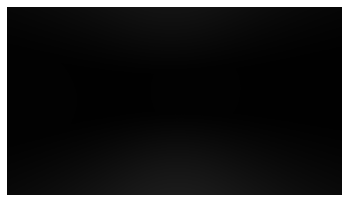

In [7]:
def display(pxl_vec):
    pp.imshow(pxl_vec.reshape((nx,ny)).T[::-1], 'gray', vmin=0., vmax=1.)
    pp.axis('off')
    pp.savefig('render.png')
    pp.show()

# sphere_center = np.random.randn(3,1)*2.+np.array([[0.,0.,10.]]).T
# sphere = dual_sphere(sphere_center, 1.0)

# sphere_pairs = raster_lines&sphere
# sphere_hits = ((sphere_pairs|sphere_pairs)[0]>0.)
# sphere_points = split_point_pair(sphere_pairs)
# sphere_dists = ((sphere_points|no)[0]).reshape(n, n).T[::-1]
# sphere_normals = sphere_points[1:4] - sphere_center; sphere_normals/=np.sum(sphere_normals**2,axis=0, keepdims=True)




def surface_map_planes(planes, camera_rays):
    # For every line in camera_rays, calculate the closest point of intersection with a plane.
    # This function expects to be provided with dual planes 
    #        - i.e., (n + d*no) or Dual(p1^p2^p3^ni)
    # Returns 3D positions and normals for every point of intersection.
    Z_out = 1.0e12*np.ones((camera_rays.mvec.shape[1]))
    positions_out = np.zeros((3,camera_rays.mvec.shape[1]))
    normals_out = np.zeros((3,camera_rays.mvec.shape[1]))
    for plane in planes:
        flats = plane|raster_lines
        s_dual = no|flats
        q = s_dual*ni*G_inv(s_dual)
        nulls_normed = normalize_null(q)
        dists = -0.5*((no|nulls_normed)[0])
        plane_normal = plane.mvec[1:4]
        points = nulls_normed.mvec[1:4]
        new_Z = ((Z_out>dists)*(points[2]>0.)*1.0)>0.0
        Z_out = np.where(new_Z, dists, Z_out)
        positions_out = np.where(new_Z, points, positions_out)
        normals_out = np.where(new_Z, plane_normal, normals_out)
    
    return positions_out, normals_out, Z_out

ground = 1.0*e2 - 5.0*ni
ceiling = -1.0*e2 - 5.0*ni
back_wall = 1.0*e3 - 20.0*ni
front_wall = -1.0*e3 - 20.0*ni
right_wall = -1.0*e1 - 20.0*ni
left_wall = 1.0*e1 - 20.0*ni


r_h = float(np.cos(0.1)) + (e13)*float(-np.sin(0.1))
r_v = float(np.cos(0.05)) + (e23)*float(-np.sin(0.05))


camera_points = r_v*r_h*(cga_points)*G_inv(r_h)*G_inv(r_v)

raster_lines = no^camera_points^ni

planes = [ground, back_wall, front_wall, right_wall, left_wall, ceiling]
visible_points, visible_normals, Z_map = surface_map_planes(planes, raster_lines)

display(1.0/Z_map)


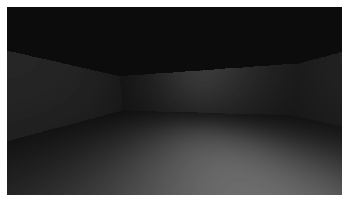

In [8]:
point_light = np.asarray([[3., 6., 3.]]).T
ambient = -1.5

light_dirs = visible_points-point_light
light_dists = np.sqrt(np.sum(light_dirs**2, axis=0, keepdims=True))
light_dirs /= light_dists
diffuse = 15.*(-np.sum((light_dirs*visible_normals), axis=0)/(light_dists**1))
total = 0.5*np.tanh((diffuse>0.)*diffuse + ambient)+0.5
display(total)